In [64]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

from scipy.optimize import minimize

from rjpo import build_2d_first_order_grad, RJPOSampler

# Example 1: UQ for a 1D deblurring problem

In [65]:
# Parameters for the problem
n = 100
reg_lambda = 1e2
blur_sigma = 1.5
noise_sigma = 0.2

# Create signal
def eval_signal(x):
    if x < 0.2:
        return 0
    elif (x >= 0.2) and (x < 0.4):
        return 1 
    elif (x >= 0.4) and (x < 0.6):
        return 0
    elif (x >= 0.6) and (x < 0.8):
        return 2
    elif (x >= 0.8) and (x <= 1.0):
        return 0
    else:
        return 0

vecfunc = np.vectorize(eval_signal)
dom = np.linspace(0, 1, 100)
x = vecfunc( dom ) + np.sin(5*dom)

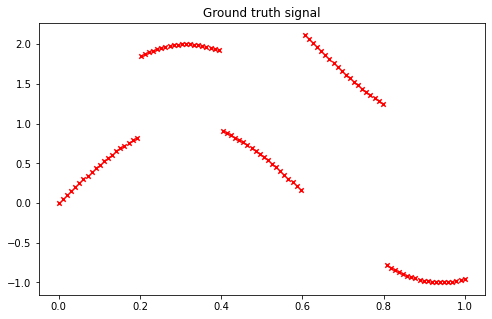

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(dom, x, marker="x", color="red", s=20.0)
plt.title("Ground truth signal")
plt.show()

In [27]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
def build_1d_first_order_grad(N: int, 
    boundary: str = "periodic",
):
    """Constructs a SciPy sparse matrix that extracts the (1D) discrete gradient of an input signal.
    Boundary parameter specifies how to handle the boundary conditions.
    """
    
    assert boundary in ["none", "periodic", "zero"], "Invalid boundary parameter."
    
    d_mat = sps.eye(N)
    d_mat.setdiag(-1,k=-1)
    d_mat = d_mat.tolil()
    
    if boundary == "periodic":
        d_mat[0,-1] = -1
    elif boundary == "zero":
        pass
    elif boundary == "none":
        d_mat = d_mat[1:,:]
    else:
        pass
    
    return d_mat

rmat = build_1d_first_order_grad(n, boundary="zero")
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [28]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(x) + noise_sigma*np.random.randn(n)

# Get solution via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

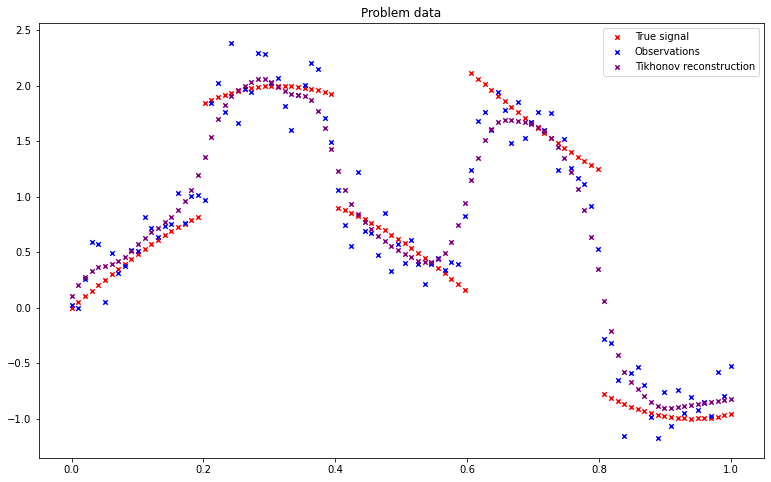

In [29]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.legend()
plt.title("Problem data")
plt.show()

## Compare sampling method with and without the accept-reject step

In [30]:
# Make RJPO sampler
Rtilde = np.sqrt(reg_lambda)*R
Ftilde = (1.0/noise_sigma)*F
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

# Compute posterior mean
posterior_mean, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

# Create sampler
rjpo_sampler = RJPOSampler([Ftilde, Rtilde], mu=posterior_mean)
sampler_data = rjpo_sampler.sample(keep_trace=True, n_samples=10000, cg_eps=1e-2)
print(f"acceptance rate: {sampler_data['acceptance_rate']}")
print(f"avg_cg_its: {sampler_data['avg_cg_its']}")

mean = np.mean(sampler_data["trace"], axis=0)
lower_quantile = np.quantile(sampler_data["trace"], q=0.025, axis=0)
upper_quantile = np.quantile(sampler_data["trace"], q=0.975, axis=0)

acceptance rate: 0.8539
avg_cg_its: 11.6795


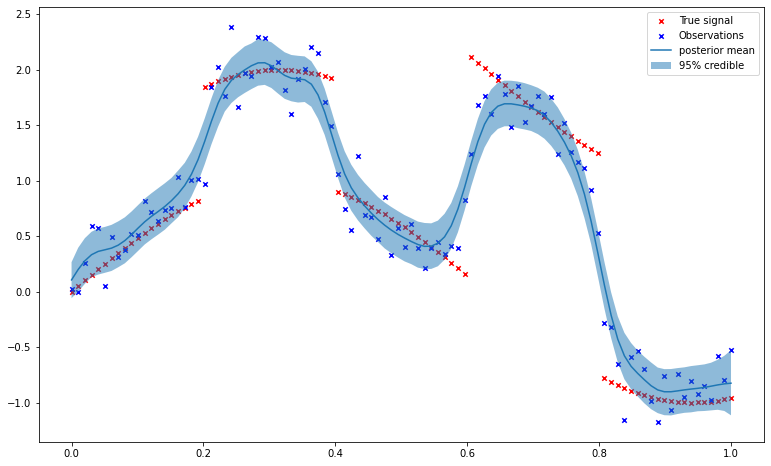

In [31]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.plot(dom, posterior_mean, label="posterior mean")
plt.fill_between(dom, lower_quantile, upper_quantile, alpha=0.5, label="95% credible")
plt.legend()
plt.show()

In [32]:
# Compare to without the AR step?
sampler_data_no_ar = rjpo_sampler.sample(keep_trace=True, n_samples=10000, cg_eps=1e-2, ar_step=False)
print(f"acceptance rate: {sampler_data_no_ar['acceptance_rate']}")

mean_no_ar = np.mean(sampler_data_no_ar["trace"], axis=0)
lower_quantile_no_ar = np.quantile(sampler_data_no_ar["trace"], q=0.025, axis=0)
upper_quantile_no_ar = np.quantile(sampler_data_no_ar["trace"], q=0.975, axis=0)

acceptance rate: 0.9999


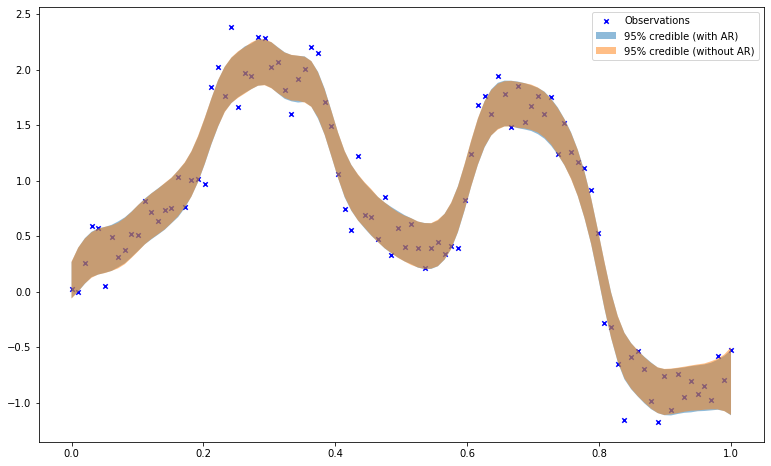

In [33]:
plt.figure(figsize=(13,8))
#plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
#plt.plot(dom, posterior_mean, label="posterior mean")
plt.fill_between(dom, lower_quantile, upper_quantile, alpha=0.5, label="95% credible (with AR)")
plt.fill_between(dom, lower_quantile_no_ar, upper_quantile_no_ar, alpha=0.5, label="95% credible (without AR)")
plt.legend()
plt.show()

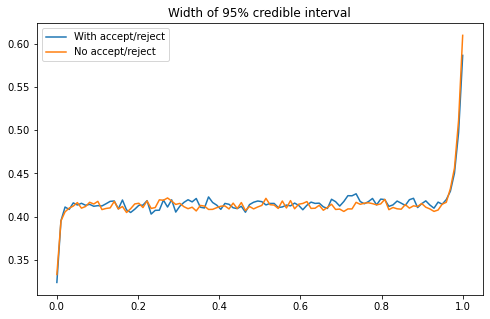

In [36]:
plt.figure(figsize=(8,5))
plt.plot(dom, upper_quantile - lower_quantile, label="With accept/reject")
plt.plot(dom, upper_quantile_no_ar - lower_quantile_no_ar, label="No accept/reject")
plt.title("Width of 95% credible interval")
plt.legend()
plt.show()

## Look at acceptance rate and avg. number of CG its per sample as a function of $\epsilon$?

In [59]:
avg_cg_its = []
acceptance_rates = []
epsilons = np.logspace(start=-5, stop=0, num=10, base=10)
# epsilons = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for eps in epsilons:
    print(f"Sampling with epsilon = {eps}")
    sampler_data = rjpo_sampler.sample(keep_trace=True, n_samples=500, cg_eps=eps, cg_maxits=1000)
    avg_cg_its.append( sampler_data["avg_cg_its"] )
    acceptance_rates.append( sampler_data["acceptance_rate"] )

Sampling with epsilon = 0.005994842503189409


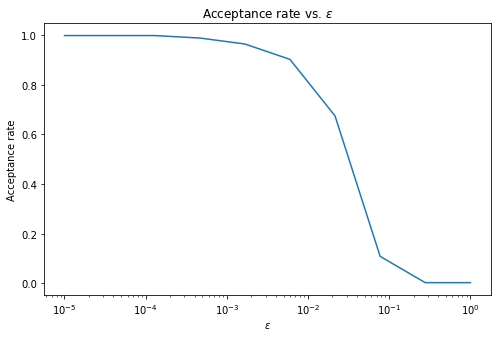

In [62]:
plt.figure(figsize=(8,5))
plt.semilogx(epsilons, acceptance_rates)
plt.title("Acceptance rate vs. $\epsilon$")
plt.xlabel("$\epsilon$")
plt.ylabel("Acceptance rate")
plt.show()

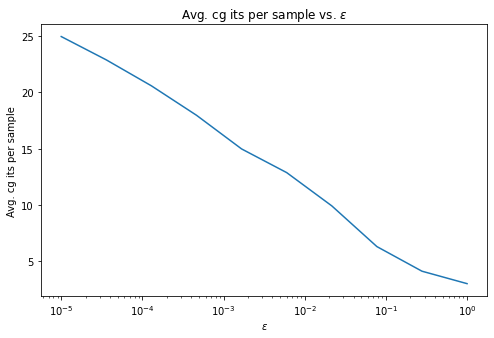

In [63]:
plt.figure(figsize=(8,5))
plt.semilogx(epsilons, avg_cg_its)
plt.title("Avg. cg its per sample vs. $\epsilon$")
plt.xlabel("$\epsilon$")
plt.ylabel("Avg. cg its per sample")
plt.show()

# Example 2: precision matrix is a 2D Laplacian operator

In [73]:
M, N = 100, 100 # grid size
rmat = build_2d_first_order_grad(M, N, boundary="zero")
R = aslinearoperator(rmat)
Q = R.T @ R #precision matrix
posterior_mean = np.zeros(M*N) # zero mean

In [78]:
# Create sampler
rjpo_sampler = RJPOSampler([R], mu=posterior_mean.flatten())
sampler_data = rjpo_sampler.sample(keep_trace=True, n_samples=500, cg_eps=1e-3)
print(f"acceptance rate: {sampler_data['acceptance_rate']}")
print(f"avg_cg_its: {sampler_data['avg_cg_its']}")

acceptance rate: 0.604
avg_cg_its: 105.668
